In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Function to load keypoints and labels
def load_keypoints_and_labels(keypoints_dir):
    """
    Load keypoints and labels from CSV files in the specified directory.

    Parameters:
    - keypoints_dir (str): Directory containing class folders with CSV files.

    Returns:
    - keypoints (list of numpy arrays): List of sequences with shape (frames, features).
    - labels (list of str): Corresponding labels for each sequence.
    """
    keypoints = []
    labels = []

    for class_folder in os.listdir(keypoints_dir):
        class_path = os.path.join(keypoints_dir, class_folder)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith(".csv"):
                    file_path = os.path.join(class_path, file)
                    data = np.loadtxt(file_path, delimiter=",")

                    # Append the data and label
                    keypoints.append(data)
                    labels.append(class_folder)

    return keypoints, labels

# Function to pad sequences to the same length
def pad_sequences(data, max_frames, max_features):
    """
    Pad sequences to have a consistent frame count with zeros.

    Parameters:
    - data (list of numpy arrays): List of sequences (keypoints).
    - max_frames (int): Maximum frame count.
    - max_features (int): Number of features per frame.

    Returns:
    - padded_data (numpy array): Padded sequences.
    """
    padded_data = []
    for seq in data:
        if seq.shape[0] < max_frames:
            padding = np.zeros((max_frames - seq.shape[0], max_features))
            padded_seq = np.vstack((seq, padding))
        else:
            padded_seq = seq[:max_frames]  # Truncate if necessary
        padded_data.append(padded_seq)

    return np.array(padded_data)

# Main script
if __name__ == "__main__":
    # Path to keypoints directory
    keypoints_dir = "/content/drive/MyDrive/keypoints"  # Replace with your directory path

    # Load keypoints and labels
    keypoints, labels = load_keypoints_and_labels(keypoints_dir)
    print(f"Loaded {len(keypoints)} sequences with corresponding labels.")

    # Determine maximum frames and features
    max_frames = max(seq.shape[0] for seq in keypoints)
    max_features = keypoints[0].shape[1]
    print(f"Maximum frames: {max_frames}, Features per frame: {max_features}")

    # Pad sequences to have consistent lengths
    keypoints_padded = pad_sequences(keypoints, max_frames, max_features)
    print(f"Padded sequences shape: {keypoints_padded.shape}")

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_categorical = to_categorical(labels_encoded)
    print(f"Number of classes: {len(label_encoder.classes_)}")

    # Split data into train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        keypoints_padded, labels_categorical, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )



Loaded 1316 sequences with corresponding labels.
Maximum frames: 116, Features per frame: 1662
Padded sequences shape: (1316, 116, 1662)
Number of classes: 10


In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(max_frames, max_features)),
    Dropout(0.2),
    LSTM(32),
    Dense(len(label_encoder.classes_), activation='softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 116, 64)             │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 116, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 454,858 (1.74 MB)

 Trainable params: 454,858 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Set a higher number of epochs but stop early if necessary
    batch_size=16,
    callbacks=[early_stopping]
)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step - accuracy: 0.3514 - loss: 1.5586 - val_accuracy: 0.3223 - val_loss: 1.5245
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.3715 - loss: 1.4545 - val_accuracy: 0.3223 - val_loss: 1.5108
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - accuracy: 0.3529 - loss: 1.4667 - val_accuracy: 0.3365 - val_loss: 1.3910
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 261ms/step - accuracy: 0.3891 - loss: 1.3723 - val_accuracy: 0.3744 - val_loss: 1.3521
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.4206 - loss: 1.3361 - val_accuracy: 0.3649 - val_loss: 1.4646
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 259ms/step - accuracy: 0.3724 - loss: 1.3834 - val_accuracy: 0.3270 - val_loss: 1.3734
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.3732 - loss: 1.5154 - val_accuracy: 0.3460 - val_loss: 1.4493


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.4624 - loss: 1.3320
Test Accuracy: 44.70%


In [ ]:
model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(max_frames, max_features)),
        Dropout(0.2),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 116, 128)            │         916,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 116, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 968,810 (3.70 MB)

 Trainable params: 968,810 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
 history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32
    )

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 690ms/step - accuracy: 0.1028 - loss: 2.2743 - val_accuracy: 0.1422 - val_loss: 2.1497
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 699ms/step - accuracy: 0.1679 - loss: 2.1668 - val_accuracy: 0.1801 - val_loss: 2.0742
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 652ms/step - accuracy: 0.2220 - loss: 2.0543 - val_accuracy: 0.2180 - val_loss: 1.9958
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 645ms/step - accuracy: 0.2321 - loss: 2.0362 - val_accuracy: 0.2133 - val_loss: 2.0357
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 656ms/step - accuracy: 0.2034 - loss: 2.0102 - val_accuracy: 0.2133 - val_loss: 1.9105
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.2401 - loss: 1.9236 - val_accuracy: 0.2417 - val_loss: 1.8629
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.2021 - loss: 1.8945 - val_accuracy: 0.2322 - val_loss: 1.8101
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 659ms/step - accuracy: 0.2457 - loss: 1.8375 - val_accu

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - accuracy: 0.3175 - loss: 1.5435
Test Accuracy: 30.68%


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 545ms/step


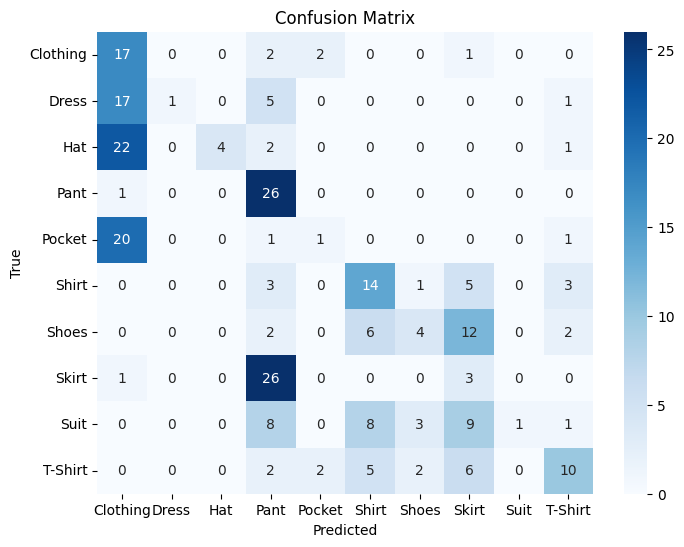

Classification Report:
              precision    recall  f1-score   support

    Clothing       0.22      0.77      0.34        22
       Dress       1.00      0.04      0.08        24
         Hat       1.00      0.14      0.24        29
        Pant       0.34      0.96      0.50        27
      Pocket       0.20      0.04      0.07        23
       Shirt       0.42      0.54      0.47        26
       Shoes       0.40      0.15      0.22        26
       Skirt       0.08      0.10      0.09        30
        Suit       1.00      0.03      0.06        30
     T-Shirt       0.53      0.37      0.43        27

    accuracy                           0.31       264
   macro avg       0.52      0.32      0.25       264
weighted avg       0.53      0.31      0.25       264



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

class_names = sorted(os.listdir(keypoints_dir))
# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format if necessary
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


In [3]:
from tensorflow.keras.layers import Masking, LSTM, Dense
model = Sequential([
        Masking(mask_value=0.0, input_shape=(max_frames, max_features)),
        LSTM(64, activation='tanh', return_sequences=False),  # LSTM with 64 units
        Dense(64, activation='tanh'),  # Fully connected layer
        Dense(10, activation='softmax')  # Output layer
    ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
 model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
 history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32
    )

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 417ms/step - accuracy: 0.7641 - loss: 0.5641 - val_accuracy: 0.6635 - val_loss: 0.7928
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - accuracy: 0.7824 - loss: 0.5597 - val_accuracy: 0.7251 - val_loss: 0.7478
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 363ms/step - accuracy: 0.8101 - loss: 0.5389 - val_accuracy: 0.7251 - val_loss: 0.7814
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accuracy: 0.7791 - loss: 0.6002 - val_accuracy: 0.6777 - val_loss: 0.8035
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.7689 - loss: 0.5833 - val_accuracy: 0.6635 - val_loss: 0.8153
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.7527 - loss: 0.5929 - val_accuracy: 0.7156 - val_loss: 0.8215
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.7852 - loss: 0.6403 - val_accuracy: 0.7062 - val_loss: 0.7535
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 354ms/step - accuracy: 0.7771 - loss: 0.5768 - val_accur

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


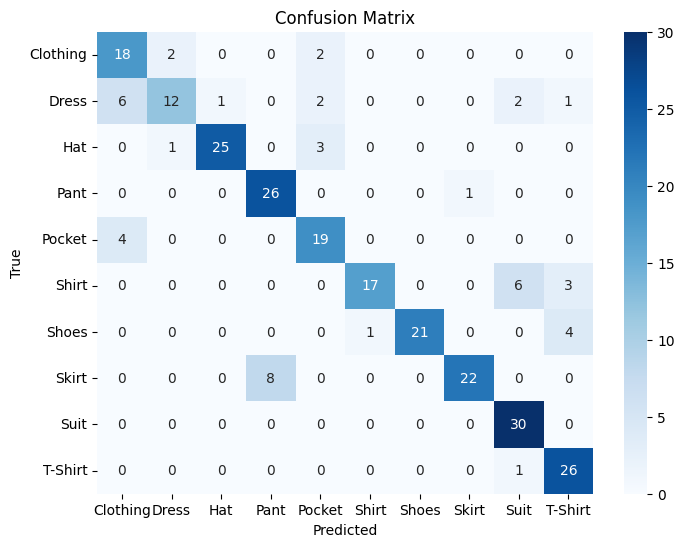

Classification Report:
              precision    recall  f1-score   support

    Clothing       0.64      0.82      0.72        22
       Dress       0.80      0.50      0.62        24
         Hat       0.96      0.86      0.91        29
        Pant       0.76      0.96      0.85        27
      Pocket       0.73      0.83      0.78        23
       Shirt       0.94      0.65      0.77        26
       Shoes       1.00      0.81      0.89        26
       Skirt       0.96      0.73      0.83        30
        Suit       0.77      1.00      0.87        30
     T-Shirt       0.76      0.96      0.85        27

    accuracy                           0.82       264
   macro avg       0.83      0.81      0.81       264
weighted avg       0.84      0.82      0.81       264



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

class_names = sorted(os.listdir(keypoints_dir))
# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format if necessary
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step


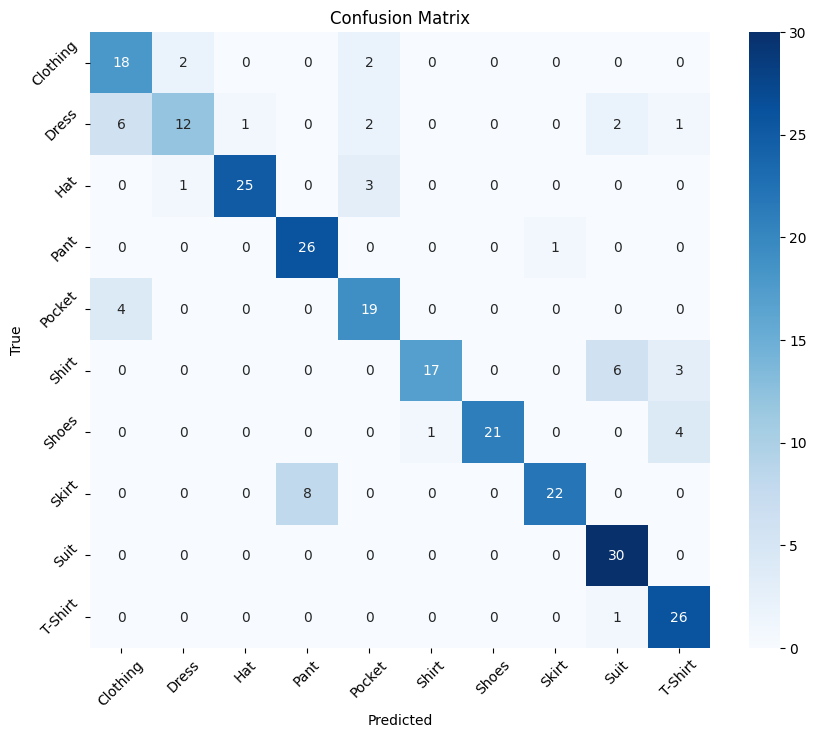

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from google.colab import files

# Assuming 'keypoints_dir' contains subdirectories named after class labels
keypoints_dir = "/content/drive/MyDrive/keypoints"
class_names = sorted(os.listdir(keypoints_dir))

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)  # Remove np.argmax if y_test is not one-hot encoded

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix and save it as an image
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Save the confusion matrix as an image
confusion_matrix_file = "confusion_matrix.png"
plt.savefig(confusion_matrix_file, dpi=300, bbox_inches='tight')
plt.show()

# Download the confusion matrix image
files.download(confusion_matrix_file)

# Generate and save the classification report
classification_report_text = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Save the classification report as a text file
classification_report_file = "classification_report.txt"
with open(classification_report_file, "w") as f:
    f.write("Classification Report\n")
    f.write("=" * 80 + "\n\n")
    f.write(classification_report_text)

# Download the classification report text file
files.download(classification_report_file)


In [ ]:

files.download(confusion_matrix_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
 history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32
    )

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 363ms/step - accuracy: 0.2185 - loss: 1.9980 - val_accuracy: 0.2133 - val_loss: 1.9405
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - accuracy: 0.2783 - loss: 1.9100 - val_accuracy: 0.1611 - val_loss: 2.0332
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 364ms/step - accuracy: 0.2212 - loss: 1.9974 - val_accuracy: 0.3649 - val_loss: 1.9375
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.2878 - loss: 1.8894 - val_accuracy: 0.3412 - val_loss: 1.9741
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.3420 - loss: 1.8819 - val_accuracy: 0.3318 - val_loss: 1.7535
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 353ms/step - accuracy: 0.3333 - loss: 1.7358 - val_accuracy: 0.3033 - val_loss: 1.7430
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.3080 - loss: 1.6601 - val_accuracy: 0.3602 - val_loss: 1.6174
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.3396 - loss: 1.6057 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step


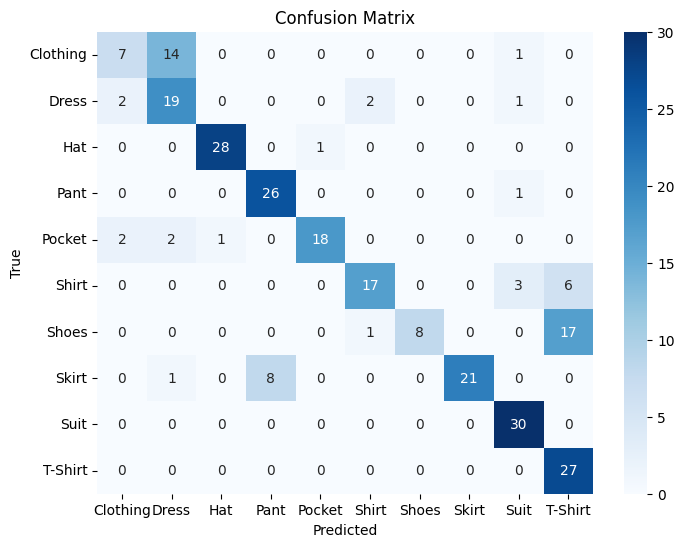

Classification Report:
              precision    recall  f1-score   support

    Clothing       0.64      0.32      0.42        22
       Dress       0.53      0.79      0.63        24
         Hat       0.97      0.97      0.97        29
        Pant       0.76      0.96      0.85        27
      Pocket       0.95      0.78      0.86        23
       Shirt       0.85      0.65      0.74        26
       Shoes       1.00      0.31      0.47        26
       Skirt       1.00      0.70      0.82        30
        Suit       0.83      1.00      0.91        30
     T-Shirt       0.54      1.00      0.70        27

    accuracy                           0.76       264
   macro avg       0.81      0.75      0.74       264
weighted avg       0.81      0.76      0.75       264



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

class_names = sorted(os.listdir(keypoints_dir))
# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format if necessary
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


In [31]:
 history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32
    )

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - accuracy: 0.9407 - loss: 0.1216 - val_accuracy: 0.8483 - val_loss: 0.4434
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 401ms/step - accuracy: 0.9655 - loss: 0.1187 - val_accuracy: 0.8863 - val_loss: 0.3806
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.9545 - loss: 0.1132 - val_accuracy: 0.8863 - val_loss: 0.3884
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 502ms/step - accuracy: 0.9561 - loss: 0.1055 - val_accuracy: 0.8673 - val_loss: 0.4382
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 400ms/step - accuracy: 0.9527 - loss: 0.1158 - val_accuracy: 0.8673 - val_loss: 0.3910
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 386ms/step - accuracy: 0.9662 - loss: 0.1046 - val_accuracy: 0.8341 - val_loss: 0.4916
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.8613 - loss: 0.3783 - val_accuracy: 0.7441 - val_loss: 0.9157
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step - accuracy: 0.8735 - loss: 0.3150 - val_accur

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step


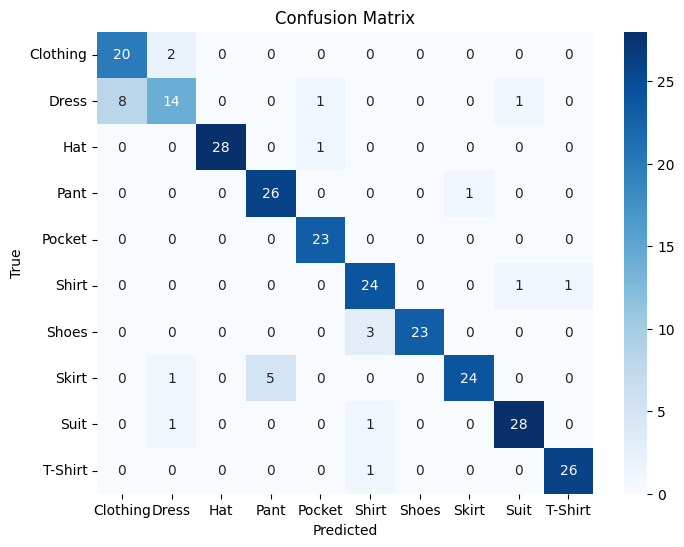

Classification Report:
              precision    recall  f1-score   support

    Clothing       0.71      0.91      0.80        22
       Dress       0.78      0.58      0.67        24
         Hat       1.00      0.97      0.98        29
        Pant       0.84      0.96      0.90        27
      Pocket       0.92      1.00      0.96        23
       Shirt       0.83      0.92      0.87        26
       Shoes       1.00      0.88      0.94        26
       Skirt       0.96      0.80      0.87        30
        Suit       0.93      0.93      0.93        30
     T-Shirt       0.96      0.96      0.96        27

    accuracy                           0.89       264
   macro avg       0.89      0.89      0.89       264
weighted avg       0.90      0.89      0.89       264



In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

class_names = sorted(os.listdir(keypoints_dir))
# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions and true labels to one-hot encoded format if necessary
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


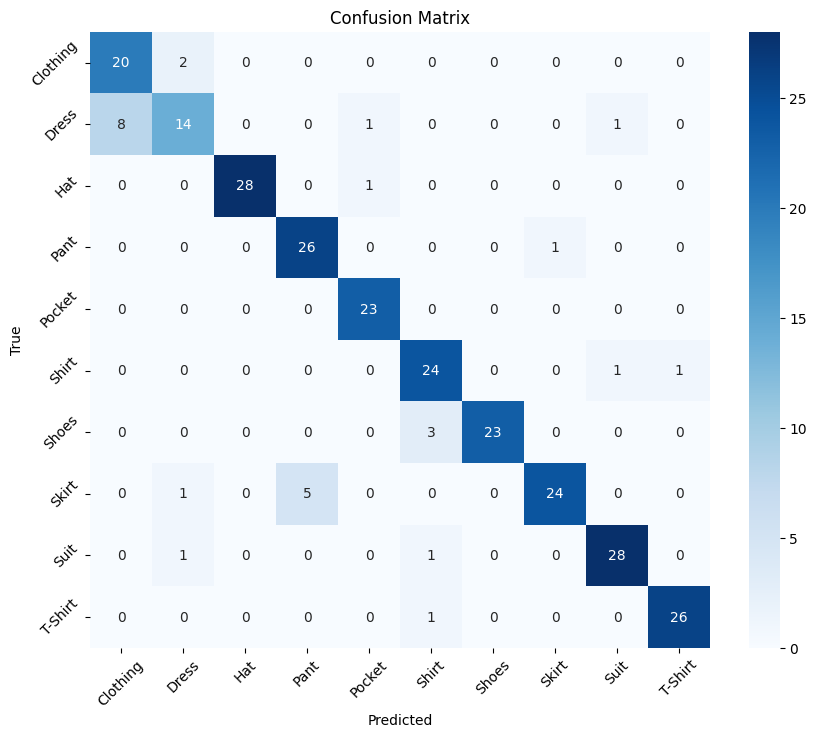

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from google.colab import files

# Assuming 'keypoints_dir' contains subdirectories named after class labels
keypoints_dir = "/content/drive/MyDrive/keypoints"
class_names = sorted(os.listdir(keypoints_dir))

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)  # Remove np.argmax if y_test is not one-hot encoded

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix and save it as an image
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Save the confusion matrix as an image
confusion_matrix_file = "confusion_matrix.png"
plt.savefig(confusion_matrix_file, dpi=300, bbox_inches='tight')
plt.show()

# Download the confusion matrix image
files.download(confusion_matrix_file)

# Generate and save the classification report
classification_report_text = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Save the classification report as a text file
classification_report_file = "classification_report.txt"
with open(classification_report_file, "w") as f:
    f.write("Classification Report\n")
    f.write("=" * 80 + "\n\n")
    f.write(classification_report_text)

# Download the classification report text file
files.download(classification_report_file)


In [29]:
files.download(confusion_matrix_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
from google.colab import files

# Save the model in TensorFlow's SavedModel format
saved_model_dir = "video_classification_model"
model.export(saved_model_dir)

# Compress the directory for downloading
shutil.make_archive(saved_model_dir, 'zip', saved_model_dir)

# Download the compressed model
files.download(f"{saved_model_dir}.zip")


Saved artifact at 'video_classification_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 116, 1662), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137337198084336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137337191336592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137337198098944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137337191347152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137337191337824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137337191349968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137337191333952: TensorSpec(shape=(), dtype=tf.resource, name=None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the model in HDF5 format
h5_model_file = "video_classification_model.h5"
model.save(h5_model_file)

# Download the model file
files.download(h5_model_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>